<a href="https://colab.research.google.com/github/anniebritton/Eco-Drought-South-Dakota/blob/main/NDVI_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Colab Set Up**

In [ ]:
# installs and import libraries
!pip install geopandas 
!pip install matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
plt.rcParams["figure.figsize"] = (20,3)

In [ ]:
# mount gogole drive
from google.colab import drive
drive.mount('/content/drive')

**Import Data**

In [305]:
# import the dataset only for the full range of NDVI data 2000 on
df_ndvi = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_NDVI_range_V2.csv')
df_ndvi['date'] = pd.to_datetime(df_ndvi['date']).dt.strftime('%Y-%m-%d')
df_ndvi['date'] = pd.to_datetime(df_ndvi['date'])
df_ndvi = df_ndvi.set_index('date')
# df_ndvi = df_ndvi.drop(['smam', 'smpm', 'PP_NDVI'], axis=1)

In [306]:
# import and create a list of pentads that the drought data is based on. 
# This will be used to calculate anomalies and average so that all of the 
# data variables match temporally
pentads = pd.read_csv('/content/drive/MyDrive/School/M.S./Courses/Capstone/Colab/Data/CSVs/drought_variable_pentads.csv')
pentads = pentads[1470:]
pentads = pentads['date'].tolist()

**Calculate Anomalies**

In [307]:
# Function that will calculate the daily mean for each variable and then 
# subsequently calculate the anomaly for each variable/day
def calculate_anomaly(df, value_col):
    
    # Group the data by day of the year and calculate the average for each day of the year
    df_daily_grouping = df.groupby(df.index.dayofyear).mean()

    # Create a dictionary mapping day of year to average value
    day_of_year_to_mean = df_daily_grouping[value_col].to_dict()

    # Map the day of year to the average value for that day of year
    df['day_of_year'] = df.index.dayofyear
    df[f'day_of_year_{value_col}_mean'] = df['day_of_year'].map(day_of_year_to_mean)

    # Calculate the daily anomaly as the difference between the original value and the average value for that day of year
    df[f'{value_col}_anomaly'] = df[value_col] - df[f'day_of_year_{value_col}_mean']

# NOTE - I am doing this before resampling we want to look at each day of the year here.
# If we did this after resampling, because of the way the pentads work, we would have
# less data to compare year to year.

# Apply the function to each column of the dataframe
for col in df_ndvi.columns:
    if col != 'date':
        calculate_anomaly(df_ndvi, col)

In [308]:
# Reduce the dataframe so that it only contains the anomaly data
df_anom = df_ndvi[df_ndvi.columns[df_ndvi.columns.str.endswith('_anomaly')]]
df_anom.insert(0, 'NDVI_anomaly', df_anom.pop('NDVI_anomaly'))

**Resample the Data to match the Pentads from the Drought Indexes, and Normalize**

In [326]:
# create an empty list to store the result dataframes
results = []

# loop through each column in the dataframe
for col in df_anom.columns:
    if col == 'NDVI_anomaly':
        result = pd.DataFrame({'date': pentads, f'{col}_5day': df_anom[col].rolling(window=5, min_periods=1).mean().loc[pentads]})
    else:
        result = pd.DataFrame({'date': pentads, f'{col}_5day': df_anom[col].rolling(window=5, min_periods=1).mean().loc[pentads]})
    result = result.set_index('date')
    results.append(result)

# concatenate the result dataframes into a single dataframe
anom_result = pd.concat(results, axis=1)

# remove the first row since that row is not based on a 5-day average
anom_result = anom_result[1:]

# normalize the data
normalized_df = (anom_result-anom_result.mean())/anom_result.std()

**~ Visualize ~**

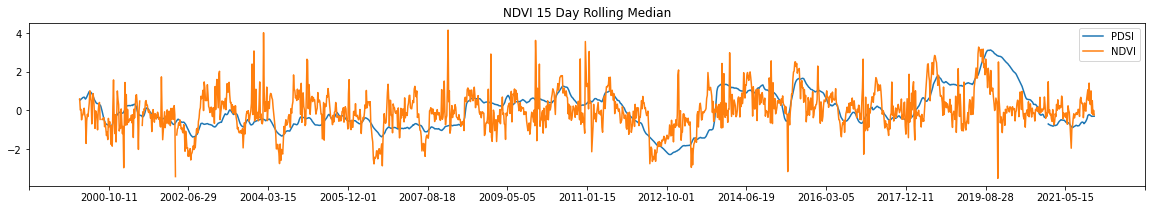

In [327]:
b = normalized_df['pdsi_anomaly_5day']
c = normalized_df['NDVI_anomaly_5day']
fig, ax = plt.subplots(1,1, )
ax.plot(b, label='PDSI')
ax.plot(c, label='NDVI')
ax.xaxis.set_major_locator(ticker.LinearLocator(numticks = 15))
ax.legend()
plt.title("NDVI 5 Day Rolling Mean")
fig.show()

**Prelim ML Tests**

In [ ]:
from scikitlearn.ensemble import RandomForestClassifier

X = normalizd_df.loc[:, 'ALL THE DATA COLUMNS minus DROUGHT BOOLEAN COLUMN'].values
Y = normalizd_df.loc[:, 'DROUGHT BOOLEAN COLUMN'].values

clf = RandomForestClassifier(n_estimators=100)
clf.fit(X, Y) 

In [ ]:
# SUBSET YOUR X AND Y INTO TRAIN/TEST SETS; for instance, take first 80% of the rows as training, last 20% as test
clf.fit(X_train, Y_train)
Y_predicted = clf.predict(X_test)

# COMPARE Y_predicted WITH Y_test.